# Assignment 3: Classical Hough Transform

## Ex. 3.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) OR circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

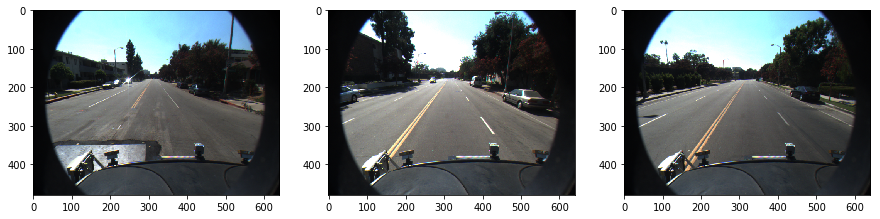

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
import warnings; warnings.simplefilter('ignore')


lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

#eye1 = io.imread('images/eye_tracking/0000.jpeg')
#eye2 = io.imread('images/eye_tracking/0050.jpeg')
#eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
#ax21 = plt.subplot(2, 3, 4)
#ax22 = plt.subplot(2, 3, 5)
#ax23 = plt.subplot(2, 3, 6)



ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

#ax21.imshow(eye1)
#ax22.imshow(eye2)
#ax23.imshow(eye3)

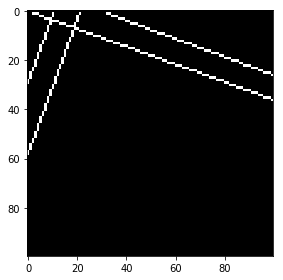

In [10]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert

%matplotlib inline
from skimage.draw import line
from skimage import io
import math
import numpy as np

def draw_line_hessian_normal(image, a, r):
    
    dimy = image.shape[1]
    dimx = image.shape[0]
    #print(image.shape)
    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(int(y0),x0,int(y1),x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret


image = np.zeros((100, 100))
image = draw_line_hessian_normal(image, 20, 20)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)


## line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

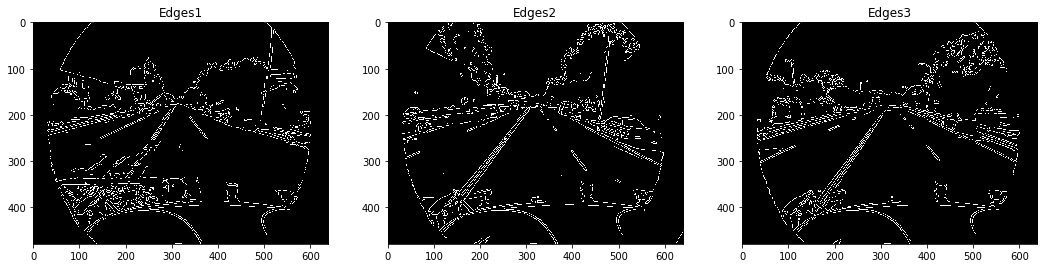

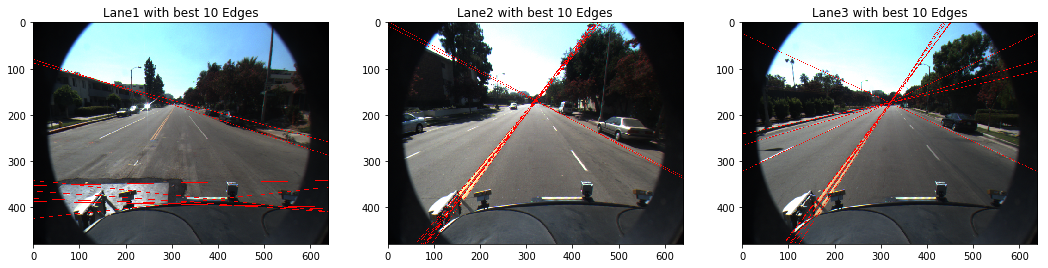

In [11]:
from math import cos, sin, radians, ceil

def draw_hessian_normal_line(image, a, r):
    res=[]
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if r==round(x*cos(radians(a)) + y*sin(radians(a))):
                res.append((x,y))  
    x0, y0= res[0]
    x1, y1 = res[-1]
    xx, yy=line(y0, x0, y1 , x1)
    image[xx, yy] = (255,0,0) 
    return image


def hough_accumulator(img):
    leng = np.hypot(img.shape[0], img.shape[1])
    leng = ceil(leng)
    accumulator = np.zeros((2 * leng, 180), dtype=np.uint8)
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            if img[y][x] > 0:
                for theta in range(-90, 90):
                    r = round(x * cos(radians(theta)) + y * sin(radians(theta))) + leng
                    accumulator[r][theta + 90] += 1
                    
    return accumulator, theta, r


#io.imshow(hough_accumulator(image))
#io.show()

'''
Local Maxima that finds the best n Parameter Combinations
'''
def find_n_local_maxima(acc,n):
    c = np.copy(acc) 
    i = 0
    combi = np.array([[0,0]]).reshape((1,2))   
    while np.size(combi) < (n*2 + 2):
        #find Max(r,theta) and add to combi
        maximum = np.amax(c)
        r, theta = np.where(c == maximum)
        if np.size(r) > 1:
            #If there are more than one Maxima, add them all
              for x in range(np.size(r)):
                    pair = np.append(r[x], theta[x]).reshape((1,2))  
                    combi = np.vstack((combi, pair))  
                    if np.size(combi) == (n*2 + 2) :
                        break
        else:
            pair = np.append(r, theta).reshape((1,2))   
            combi = np.vstack((combi, pair))  
        c[c == maximum] = 0
    combi = np.delete(combi, 0, 0) 
    return combi
                   

edges1  = feature.canny(color.rgb2gray(lane1))   
edges2  = feature.canny(color.rgb2gray(lane2))
edges3  = feature.canny(color.rgb2gray(lane3))  

'''
Draw best n edges or original image
'''
def draw_edges_on_image(img, edges):
    acc, theta, r = hough_accumulator(edges)
    leng = np.hypot(img.shape[0],img.shape[1])
    leng = ceil(leng)
    combi = find_n_local_maxima(acc, 10)
    for x,y in combi:
        img = draw_hessian_normal_line(img, y - 90, x - leng)
    return img, acc

"""
Help method for displaying a list of images in a row
"""
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

    
img1, acc1 = draw_edges_on_image(lane1, edges1)
img2, acc2 = draw_edges_on_image(lane2, edges2)
img3, acc3 = draw_edges_on_image(lane3, edges3)
    
show_images(images=[edges1, edges2, edges3], titles=['Edges1', 'Edges2', 'Edges3'])
#show_images(images=[acc1, acc2, acc3], titles=['Accumulator1', 'Accumulator2', 'Accumulator3'])
show_images(images=[img1, img2, img3], titles=['Lane1 with best 10 Edges', 
                                               'Lane2 with best 10 Edges', 
                                               'Lane3 with best 10 Edges'])

## circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

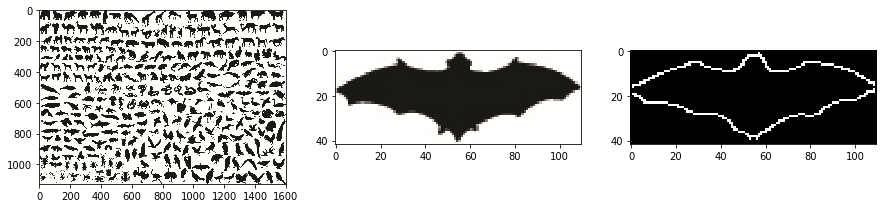

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
from math import cos, sin, radians, ceil



animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(color.rgb2gray(bat), 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)

In [29]:
from scipy import ndimage, misc
from collections import defaultdict
import numpy as np
from skimage import io, data, feature, color

def get_gradient(image):
    image_gray=color.rgb2gray(image)
    sobelx=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobely=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    edge = feature.canny(image_gray, 2)
    sx=ndimage.convolve(edge, sobelx)
    sy=ndimage.convolve(edge, sobely)
    gradient=np.arctan2(sy,sx)* 180 / np.pi
    return edge,gradient

def template_origin(template): 
    x0=0
    y0=0
    i=0
    for x in range(template.shape[1]):
        for y in range(template.shape[0]): 
            if template[y, x] == True:
                x0+= x
                y0+= y
                i+= 1
    xc = ceil(x0/i) 
    yc = ceil(y0/i) 
    return(yc,xc)

def calculate_r_table(edge, gradient, origin): 
    r_table = defaultdict(list)
    for x in range(edge.shape[1]):
        for y in range(edge.shape[0]): 
            if edge[y, x] == True:
                r = (origin[0] - y, origin[1] - x)
                r_table[gradient[y, x]].append(r) 
    return r_table


def get_accumulator(image, gradient): 
    accumulator = np.zeros(image.shape) 
    for y in range (image.shape[0]):
        for x in range(image.shape[1]): 
            if image[y,x]:
                for r in r_table[gradient[y,x]]:
                    accum_y, accum_x = y+r[0], x+r[1] 
                    if accum_y < accumulator.shape[0] and accum_x < accumulator.shape[1]:
                        accumulator[accum_y, accum_x] += 1
    return accumulator


#Tests the r-table by drawing the points
def test_r_table(r): 
    test = np.zeros(bat.shape) 
    test = test-20
    for key,values in r.items():
        for value in values: 
            test[origin[0]-value[0], origin[1]-value[1]] = key
    test = test[:,:,0]
    fig = plt.figure(figsize=(15, 10))
    imgplot = plt.imshow(test, cmap="magma", vmin=-20, vmax=100)
    plt.colorbar()


def localize_image(animals, bat_accumulator):

    fig = plt.figure(figsize=(40, 28))
    fig.add_subplot(2,2,4)
    plt.title('Template Detection')
    plt.imshow(animals)
    
    n = find_n_local_maxima(bat_accumulator, 10)
    print(n)
    ys = []
    xs = []
    for x,y in n:
        xs.append(x)
        ys.append(y)
    print(xs)
    print(ys)
    for x in range(0, animals.shape[0]):
        for y in range(0, animals.shape[1]):
            if (x in xs) and (y in ys):
                plt.scatter(xs, ys, marker='o', color='r')
    plt.show()


[[ 0.  0.  1. ...  1.  3.  1.]
 [ 1.  0.  0. ...  2.  0.  1.]
 [ 0.  1.  4. ...  0.  2.  3.]
 ...
 [ 4.  9.  4. ...  3.  8. 18.]
 [ 4.  4.  7. ... 13. 18. 22.]
 [ 3.  1.  3. ... 18.  5.  5.]]
[[ 18  55]
 [ 18  54]
 [ 18  56]
 [ 18  53]
 [ 18  57]
 [ 17  57]
 [ 19  53]
 [ 18  52]
 [ 18  58]
 [ 40 109]]
[18, 18, 18, 18, 18, 17, 19, 18, 18, 40]
[55, 54, 56, 53, 57, 57, 53, 52, 58, 109]


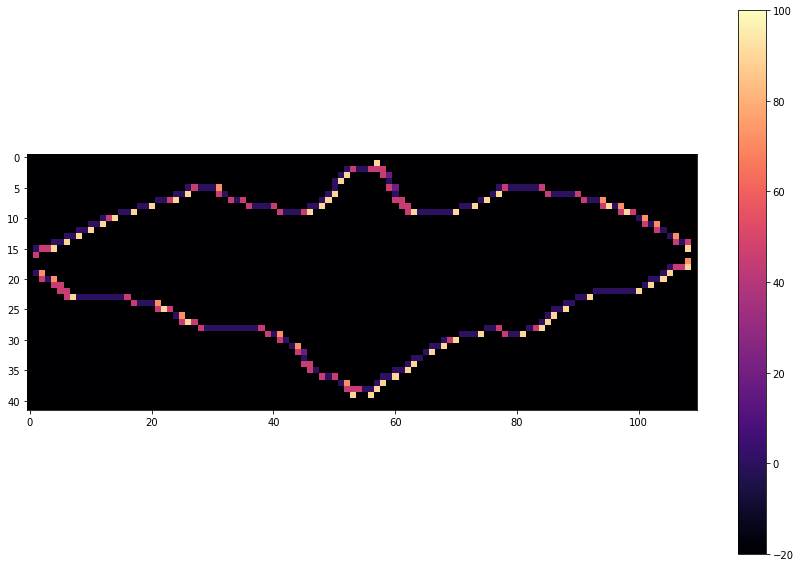

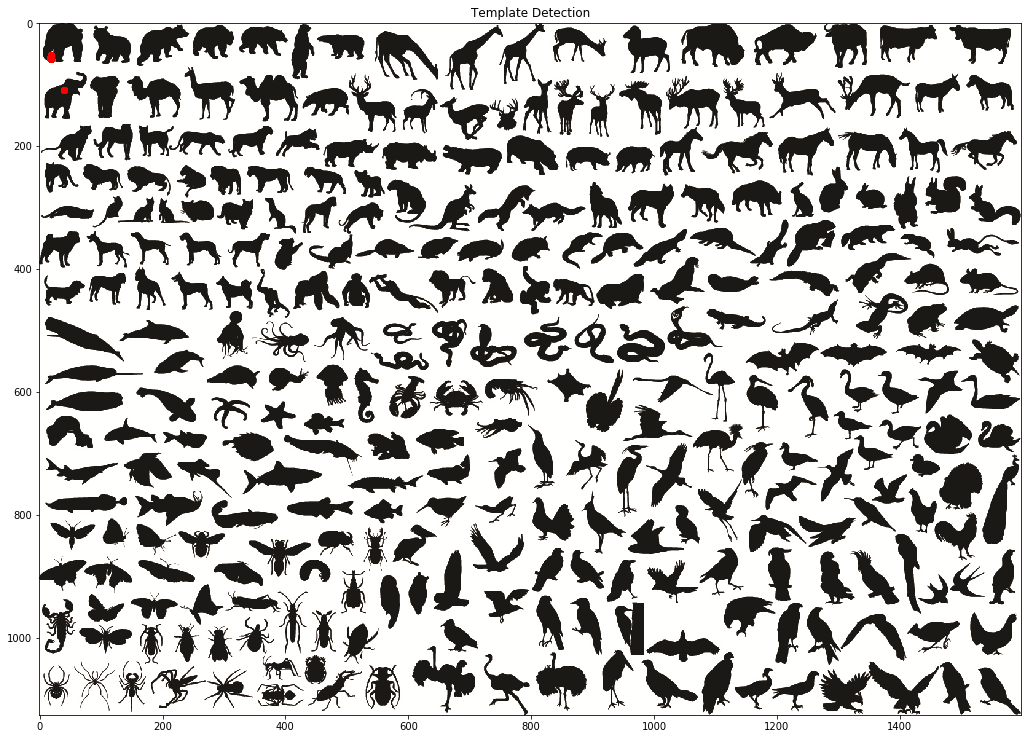

In [30]:
edge, gradient = get_gradient(bat)
origin = template_origin(edge)
r_table = calculate_r_table(edge, gradient, origin)
test_r_table(r_table)

bat_accumulator = get_accumulator(edge, gradient)

localize_image(animals, bat_accumulator)


* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**RESULT**)